In [0]:
import requests
import tqdm
from pandas.io.json import json_normalize
import seaborn as sns

Upload your Github token to `github_auth_key.txt`

In [0]:
key = open('github_auth_key.txt', 'r').read().strip()

Note that I barely know GraphQL: I made this query in Github's API explorer

TODO: handle pagination

In [0]:
# An example to get the remaining rate limit using the Github GraphQL API.
headers = {'Authorization': 'token ' + key}


def run_query(query): # A simple function to use requests.post to make the API call. Note the json= section.
    request = requests.post('https://api.github.com/graphql', json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))

In [0]:
def get_next_paged_result(result):
  if result is None:
    end_cursor_string = ''
  else:
    end_cursor_string = 'after: "{}"'.format(result['data']['viewer']['starredRepositories']['pageInfo']['endCursor'])
  new_query_string = """{{
    viewer {{
      starredRepositories(first: 100, {}) {{
        pageInfo {{
          startCursor
          hasNextPage
          endCursor
        }}
        nodes {{
          name
          owner {{
            login
          }}
          description
          languages(first: 1) {{
            nodes {{
              name
            }}
          }}
          repositoryTopics(first: 10) {{
            nodes {{
              topic {{
                name
              }}
            }}
          }}
        }}
      }}
    }}
  }}""".format(end_cursor_string)
  return run_query(new_query_string)

In [5]:
next_result = None
repo_information = []
for __ in tqdm.tqdm(range(5)):
  next_result = get_next_paged_result(next_result)
  repo_information = repo_information + next_result['data']['viewer']['starredRepositories']['nodes']

100%|██████████| 5/5 [00:07<00:00,  1.26s/it]


In [6]:
starred_repo_df = json_normalize(repo_information)
starred_repo_df.index = starred_repo_df['name']
starred_repo_df['topics'] = starred_repo_df['repositoryTopics.nodes'].apply(lambda recs: [r['topic']['name'] for r in recs])

starred_repo_df

,description,languages.nodes,name,owner.login,repositoryTopics.nodes,topics
name,,,,,,
ml-readings,A list of papers / videos / tutorials / blog p...,[],ml-readings,debasishg,[],[]
ofxTSNE,t-SNE dimensionality reduction technique for o...,[{'name': 'Python'}],ofxTSNE,genekogan,[],[]
scala-whats-that-called,What do you call that?... for Scala,[],scala-whats-that-called,andyscott,"[{'topic': {'name': 'scala'}}, {'topic': {'nam...","[scala, guide]"
cats,"Lightweight, modular, and extensible library f...",[{'name': 'Scala'}],cats,typelevel,[],[]
spire,Powerful new number types and numeric abstract...,[{'name': 'Scala'}],spire,typelevel,[],[]
stanford_dl_ex,Programming exercises for the Stanford Unsuper...,[],stanford_dl_ex,amaas,[],[]
awesome-deep-learning,A curated list of awesome Deep Learning tutori...,[],awesome-deep-learning,ChristosChristofidis,"[{'topic': {'name': 'deep-learning'}}, {'topic...","[deep-learning, neural-network, machine-learni..."
CADL,Course materials/Homework materials for the FR...,[{'name': 'Jupyter Notebook'}],CADL,pkmital,"[{'topic': {'name': 'jupyter-notebook'}}, {'to...","[jupyter-notebook, neural-network, tensorflow,..."
breeze,Breeze is a numerical processing library for S...,[{'name': 'Scala'}],breeze,scalanlp,[],[]


In [7]:
starred_repo_df.drop_duplicates('name').shape

(329, 6)

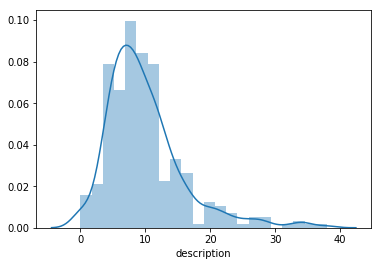

In [8]:
sns.distplot(starred_repo_df['description'].str.split().apply(lambda l: 0 if l is None else len(l)));